# Warning :

# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 :

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU


In [1]:
import argparse
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
import torchmetrics as tm
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from icecream import ic
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from torch.autograd import Variable
from tqdm import tqdm

# Partie 1 : Architecture VGG16


## Question 3 : Bonus

From the [PyTorch documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html), the VGG input has to be `(C, H, W)` :

> The inference transforms are available at VGG16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].


In [2]:
torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


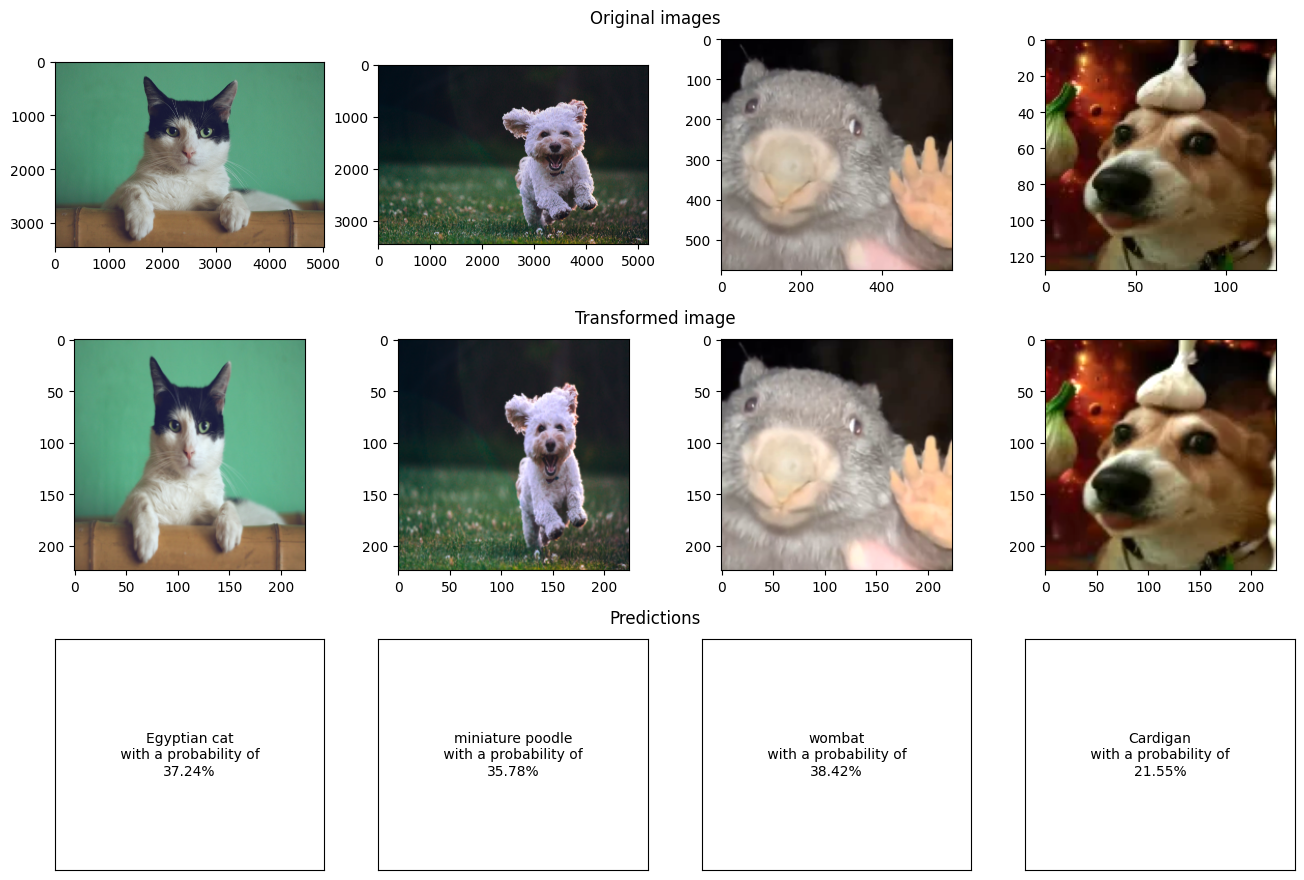

In [7]:
dog_meme = Image.open("kadaver-vanilla.webp")
bobr = Image.open("bobr.png").convert("RGB")  # 4 channels here
dog = Image.open("dog.jpg")
cat = Image.open("cat.jpg")

vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
imagenet_classes = pickle.load(
    open("imagenet_classes.pkl", "rb")
)  # chargement du nom des classes


def print_min_max(img):
    img2 = np.array(img)
    print("Min: %.3f, Max: %.3f" % (img2.min(), img2.max()))
    print(img2.shape)
    return img


def manual_norm(img):
    m = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (img - m) / std


model_transform_pipeline = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
to_view_transform_pipeline = transforms.Compose(
    # let's reporduce the model transformation here
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((226, 226), interpolation=Image.BILINEAR),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: np.array(img) / 225.0),
    ]
)


fig = plt.figure(figsize=(16, 9))
# fig.suptitle('')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
axs = subfigs[0].subplots(nrows=1, ncols=4)
subfigs[0].suptitle("Original images")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    ax.imshow(img)

axs = subfigs[1].subplots(nrows=1, ncols=4)
subfigs[1].suptitle("Transformed image")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    ax.imshow(to_view_transform_pipeline(img))

axs = subfigs[2].subplots(nrows=1, ncols=4)
subfigs[2].suptitle("Predictions")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    x = model_transform_pipeline(img).unsqueeze(0)  # to batch
    y_hat = vgg16(x).squeeze()
    y_hat = torch.nn.functional.softmax(y_hat, dim=0)
    idx = y_hat.argmax()
    txt = (
        imagenet_classes[idx.item()].split(",")[0]
        + f"\n with a probability of \n{y_hat.max().item():.02%}"
    )  # if multiple classes
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis="y", which="both", right=False, left=False, labelleft=False)
    ax.text(0.5, 0.5, txt, horizontalalignment="center", verticalalignment="center")
fig.savefig("predictions.pdf", dpi=300, bbox_inches="tight")

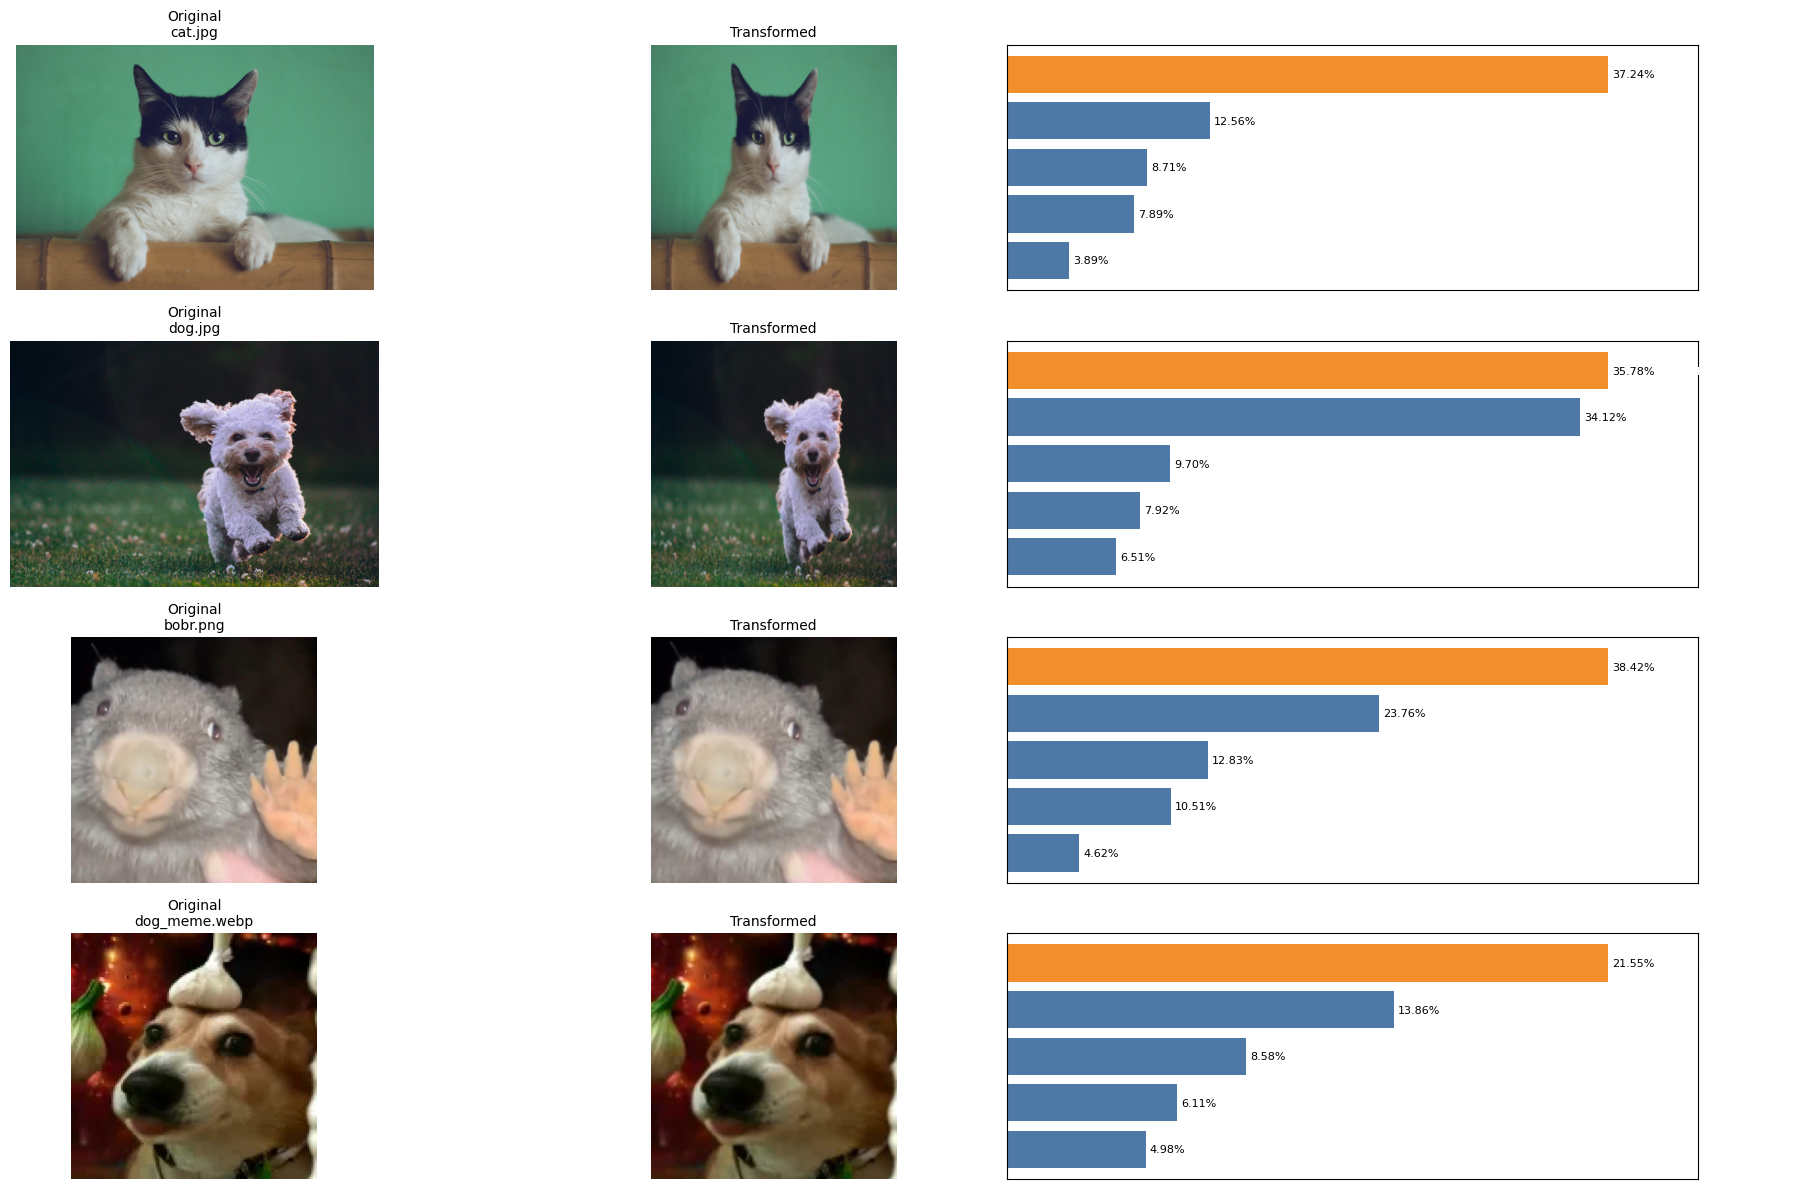

In [29]:
dog_meme = Image.open("kadaver-vanilla.webp")
bobr = Image.open("bobr.png").convert("RGB")  # # conversion because 4 channels
dog = Image.open("dog.jpg")
cat = Image.open("cat.jpg")

images = {
    "cat.jpg": cat,
    "dog.jpg": dog,
    "bobr.png": bobr.convert("RGB"),  # Convert here and associate with the filename
    "dog_meme.webp": dog_meme
}

# VGG16 model and class names
vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
imagenet_classes = pickle.load(open("imagenet_classes.pkl", "rb"))

# Transformation pipelines
model_transform_pipeline = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
to_view_transform_pipeline = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((226, 226), interpolation=Image.BILINEAR),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: np.array(img) / 255.0),
    ]
)

def get_top_predictions(img, top_k=5):
    x = model_transform_pipeline(img).unsqueeze(0)
    y_hat = vgg16(x).squeeze()
    y_hat = torch.nn.functional.softmax(y_hat, dim=0)
    top_values, top_indices = torch.topk(y_hat, top_k)
    top_predictions = [imagenet_classes[idx.item()] for idx in top_indices]
    return top_predictions, top_values.detach().numpy()


# Create a figure with specified size and a GridSpec layout
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 3)  # 4 rows for images, 3 columns for different sections

# Iterate over each image and its transformed version, and the predictions
for i, (filename, img) in enumerate(images.items()):
    # Original image
    ax_original = fig.add_subplot(gs[i, 0])
    ax_original.imshow(img)
    ax_original.set_title(f'Original\n{filename}', fontsize=10)
    ax_original.axis('off')

    # Transformed image
    ax_transformed = fig.add_subplot(gs[i, 1])
    ax_transformed.imshow(to_view_transform_pipeline(img))
    ax_transformed.set_title('Transformed', fontsize=10)
    ax_transformed.axis('off')

    # Top 5 predictions
    predictions, values = get_top_predictions(img)
    predictions, values = zip(*sorted(zip(predictions, values), key=lambda x: x[1], reverse=True))
    ax_predictions = fig.add_subplot(gs[i, 2])
    bar_colors = ['#f28e2b' if j == 0 else '#4e79a7' for j in range(len(predictions))]
    bars = ax_predictions.barh(predictions, values, color=bar_colors)
    ax_predictions.set_xlim(0, max(values) * 1.15)
    ax_predictions.invert_yaxis()  # Best prediction at the top
    ax_predictions.set_xticks([])  # Hide x-axis ticks
    ax_predictions.set_yticks([])  # Hide y-axis ticks

    # Use bar_label to add labels to the bars
    ax_predictions.bar_label(bars, labels=[f'{pred}' for pred in predictions], padding=3, color='white', fontsize=8)
    ax_predictions.bar_label(bars, labels=[f'{val:.02%}' for val in values], padding=3, color='black', fontsize=8, label_type='edge')

plt.tight_layout()
fig.savefig("predictions_v2.pdf", dpi=300, bbox_inches="tight")

## Question 4: Bonus

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene


In [6]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
# !unzip 15ScenesData.zip
# !rm 15ScenesData.zip

## Feature extraction with VGG16

In [7]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
def get_dataset(
    batch_size,
    path,
    transform=None,
):
    def duplicateChannel(img):
        img = img.convert("RGB")
        # np_img = np.array(img, dtype=np.uint8)
        # np_img = np.dstack([np_img, np_img, np_img])
        # img = Image.fromarray(np_img, 'RGB')
        return img

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    if not transform:
        transform = (
            transforms.Compose(
                [  # Pré-traitement à faire
                    transforms.Resize((224, 224), interpolation=Image.NEAREST),
                    transforms.Lambda(duplicateChannel),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            ),
        )

    train_dataset = datasets.ImageFolder(path + "/train", transform=transform)

    val_dataset = datasets.ImageFolder(path + "/test", transform=transform)

    CUDA = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=CUDA,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=CUDA,
        num_workers=2,
    )

    return train_loader, val_loader


class VGG16relu17(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features[:-1]
        self.avgpool = vgg16.avgpool
        self.classifier = vgg16.classifier[:-2]

    def forward(self, x):
        # ic(x.size())
        x = self.features(x)
        x = self.avgpool(x)
        # ic(x.size())
        x = x.view(x.size(0), -1)
        # ic(x.size())
        x = self.classifier(x)
        return x


PRINT_INTERVAL = 50


def extract_features(data, model, device):
    X = torch.tensor([], device=device)
    y = torch.tensor([])

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print("Batch {0:03d}/{1:03d}".format(i, len(data)))
        input = input.to(device)
        X = torch.cat((X, model(input)))
        y = torch.cat((y, target))
    return X, y


# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
def extract_from_model(model, path="15SceneData", batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Instanciation de VGG16")
    w = torchvision.models.VGG16_Weights.IMAGENET1K_V1
    model_transform_pipeline = w.transforms()
    vgg16 = torchvision.models.vgg16(weights=w)

    print("Instanciation de VGG16relu7")
    model = model(vgg16)
    model.eval()
    model.to(device)

    # On récupère les données
    print("Récupération des données")
    train, test = get_dataset(batch_size, path, transform=model_transform_pipeline)

    # Extraction des features
    print("Feature extraction")
    with torch.no_grad():
        X_train, y_train = extract_features(train, model, device=device)
        X_test, y_test = extract_features(test, model, device=device)
    return X_train.cpu(), X_test.cpu(), y_train.cpu(), y_test.cpu()


X_train, X_test, y_train, y_test = extract_from_model(VGG16relu17)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


## Training SVM classifiers

In [10]:
# Apprentissage et évaluation des SVM à faire
print("Apprentissage du SVM sans normalization")
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test))
print("Accuracy = %f" % accuracy)

print("Apprentissage du SVM avec normalization")
X_train_normalized = nn.functional.normalize(X_train, p=2, dim=1)
X_test_normalized = nn.functional.normalize(X_test, p=2, dim=1)
svm = LinearSVC(C=1.0, dual="auto", max_iter=1000).fit(X_train_normalized, y_train)
accuracy = accuracy_score(y_test, svm.predict(X_test_normalized))
print("Accuracy = %f" % accuracy)

Apprentissage du SVM sans normalization


/tempory/M2-DAC/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy = 0.894472
Apprentissage du SVM avec normalization
Accuracy = 0.900838


## Going further

### Changing layers

### SVM tunning

In [13]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split

# # Set the parameters by cross-validation
# param_grid = [
#     {"C": [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2], "dual": ["auto"], "max_iter":[2000]},
# ]

# # Create a classifier object with the SVC class
# svc = LinearSVC()

# # Create the grid search object
# grid_search = GridSearchCV(svc, param_grid, n_jobs=-1)

# # Fit the grid search object to our data to compute the best model
# grid_search.fit(X_train_normalized, y_train)

# # Print out the results of grid search
# print("Best parameters found:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

# # Use the best estimator to make predictions on the test set
# best_svc = grid_search.best_estimator_
# y_pred = best_svc.predict(X_test)

# # Calculate the accuracy score
# test_accuracy = accuracy_score(y_test, y_pred)
# test_accuracy

Best parameters found: {'C': 1.75, 'dual': 'auto', 'max_iter': 2000}
Best cross-validation score: 0.8960000000000001


0.8576214405360134

In [14]:
# for c in [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2] + list(range(2, 15)):
#     svm = LinearSVC(C=c, dual="auto", max_iter=2000).fit(X_train_normalized, y_train)
#     accuracy = accuracy_score(y_test, svm.predict(X_test_normalized))
#     print(f"Accuracy for {c}= {accuracy}")

Accuracy for 0.25= 0.8921273031825796
Accuracy for 0.5= 0.8968174204355109
Accuracy for 0.75= 0.9005025125628141
Accuracy for 1= 0.9008375209380235
Accuracy for 1.25= 0.8998324958123953
Accuracy for 1.5= 0.8991624790619765
Accuracy for 1.75= 0.8994974874371859
Accuracy for 2= 0.8994974874371859
Accuracy for 2= 0.8994974874371859
Accuracy for 3= 0.8984924623115578
Accuracy for 4= 0.8984924623115578
Accuracy for 5= 0.8991624790619765
Accuracy for 6= 0.8991624790619765
Accuracy for 7= 0.8988274706867672
Accuracy for 8= 0.8991624790619765
Accuracy for 9= 0.8984924623115578
Accuracy for 10= 0.8981574539363484
Accuracy for 11= 0.8974874371859296
Accuracy for 12= 0.8968174204355109
Accuracy for 13= 0.8964824120603015
Accuracy for 14= 0.8961474036850922


### Using a NN as output classifier

#### Independantly of VGG

In [18]:
def run_epoch(
    loader, model, loss_fn, optimizer=None, logger=None, device="cuda", num_classes=18
):
    loss_list = []
    acc = tm.classification.Accuracy(task="multiclass", num_classes=num_classes)
    acc.to(device)
    model.to(device)
    model.train() if optimizer else model.eval()
    for input, target in loader:
        input = input.to(device)
        target = target.to(device)

        # ic(input.size())
        # ic(target.size())
        output = model(input)
        # ic(output)
        # ic(target)
        loss = loss_fn(output, target)
        loss_list.append(loss.item())
        acc(output.argmax(1), target)
        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return np.array(loss_list).mean(), acc.compute().item()


class MLP(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,15)
        self.droput = nn.Dropout(dropout_rate)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.001
nb_epoch = 10


train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_normalized, y_train.type(torch.LongTensor)),
    batch_size=8,
    shuffle=True,
    num_workers=2,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_normalized, y_test.type(torch.LongTensor)),
    batch_size=8,
    shuffle=False,
    num_workers=2,
)
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(nb_epoch)):
    mean_train_loss, acc_train = run_epoch(
        train_loader, model, loss_fn, optimizer, device=device, num_classes=15
    )
    mean_test_loss, acc_test = run_epoch(test_loader, model, loss_fn, device=device, num_classes=15)
    ic(mean_train_loss)
    ic(acc_train)
    ic(mean_test_loss)
    ic(acc_test)

  0%|          | 0/10 [00:00<?, ?it/s]

ic| mean_train_loss: 1.092449393955634
ic| acc_train: 0.6346666812896729
ic| mean_test_loss: 0.41472541920611644
ic| acc_test: 0.863986611366272
 10%|█         | 1/10 [00:01<00:13,  1.50s/it]ic| mean_train_loss: 0.3142604698288314
ic| acc_train: 0.8939999938011169
ic| mean_test_loss: 0.3755288551667989
ic| acc_test: 0.8659966588020325
 20%|██        | 2/10 [00:02<00:11,  1.42s/it]ic| mean_train_loss: 0.1878631155432618
ic| acc_train: 0.9359999895095825
ic| mean_test_loss: 0.41320054206523754
ic| acc_test: 0.8569514155387878
 30%|███       | 3/10 [00:04<00:10,  1.54s/it]ic| mean_train_loss: 0.11502128419902255
ic| acc_train: 0.9566666483879089
ic| mean_test_loss: 0.39760222467698125
ic| acc_test: 0.8767169117927551
 40%|████      | 4/10 [00:05<00:08,  1.43s/it]ic| mean_train_loss: 0.060506550792389195
ic| acc_train: 0.981333315372467
ic| mean_test_loss: 0.5221043952924349
ic| acc_test: 0.8525963425636292
 50%|█████     | 5/10 [00:07<00:07,  1.46s/it]ic| mean_train_loss: 0.03636538037151

On obtient les même performances que partout

#### With of VGG

In [15]:
class VGG16_custom_classifier(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features[:-1]
        self.avgpool = vgg16.avgpool
        self.classifier = MLP(dropout_rate=0.8)

    def forward(self, x):
        # ic(x.size())
        x = self.features(x)
        x = self.avgpool(x)
        # ic(x.size())
        x = x.view(x.size(0), -1)
        # ic(x.size())
        x = self.classifier(x)
        return x

vgg16_custom_classifier = VGG16_custom_classifier(vgg16)
for epoch in tqdm(range(nb_epoch)):
    mean_train_loss, acc_train = run_epoch(
        train_loader, model, loss_fn, optimizer, device=device, num_classes=15
    )
    mean_test_loss, acc_test = run_epoch(test_loader, model, loss_fn, device=device, num_classes=15)
    ic(mean_train_loss)
    ic(acc_train)
    ic(mean_test_loss)
    ic(acc_test)

  0%|          | 0/10 [00:00<?, ?it/s]

ic| mean_train_loss: 0.00013541032976178182
ic| acc_train: 1.0
ic| mean_test_loss: 0.6202366764351898
ic| acc_test: 0.8897822499275208
 10%|█         | 1/10 [00:01<00:15,  1.75s/it]ic| mean_train_loss: 0.00023649172409322808
ic| acc_train: 1.0
ic| mean_test_loss: 0.628921393054098
ic| acc_test: 0.8907872438430786
 20%|██        | 2/10 [00:03<00:13,  1.64s/it]ic| mean_train_loss: 0.00010616442639418435
ic| acc_train: 1.0
ic| mean_test_loss: 0.6495241079166766
ic| acc_test: 0.8887771964073181
 30%|███       | 3/10 [00:04<00:10,  1.45s/it]ic| mean_train_loss: 0.00014444434018702048
ic| acc_train: 1.0
ic| mean_test_loss: 0.6460372686776643
ic| acc_test: 0.8897822499275208
 40%|████      | 4/10 [00:05<00:08,  1.43s/it]ic| mean_train_loss: 0.0002446072395777472
ic| acc_train: 1.0
ic| mean_test_loss: 0.6700967646118252
ic| acc_test: 0.8884422183036804
 50%|█████     | 5/10 [00:07<00:06,  1.37s/it]ic| mean_train_loss: 0.00013538849753197058
ic| acc_train: 1.0
ic| mean_test_loss: 0.678333794257

### Dimensionality reduction